# Data exploration

Display images with the ground truth mask and the predicted one for comparison

In [7]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import coco as coco2  # for predictions
from cocoeval import COCOeval
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
import sys
from mrcnn import visualize
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

In [8]:
data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "data/train/images"
TRAIN_ANNOTATIONS_PATH = "data/train/annotation.json"
TRAIN_ANNOTATIONS_SMALL_PATH = "data/train/annotation-small.json"

VAL_IMAGES_DIRECTORY = "data/val/images"
VAL_ANNOTATIONS_PATH = "data/val/annotation.json"
VAL_ANNOTATIONS_SMALL_PATH = "data/val/annotation-small.json"

In [9]:
# pick "TRAIN" or "VAL" image set
img_set = "TRAIN"
#img_set = "VAL"
IMAGE_DIR = eval(img_set + "_IMAGES_DIRECTORY")
ANNOTATIONS_PATH = eval(img_set + "_ANNOTATIONS_SMALL_PATH")
coco = COCO(ANNOTATIONS_PATH)
image_ids = coco.getImgIds(catIds=coco.getCatIds())
print(IMAGE_DIR)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
data/train/images


In [10]:
# settings for predictions
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Inference config
class InferenceConfig(coco2.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()

# load model weights in memory
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)
class_names = ['BG', 'building']


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

## Show training bboxes

122301
data/train/images/000000122301.jpg
Processing 5 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (5, 320, 320, 3)      min: -114.70000  max:  150.10000  float64
image_metas              shape: (5, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (5, 25575, 4)         min:   -1.13492  max:    1.93429  float32


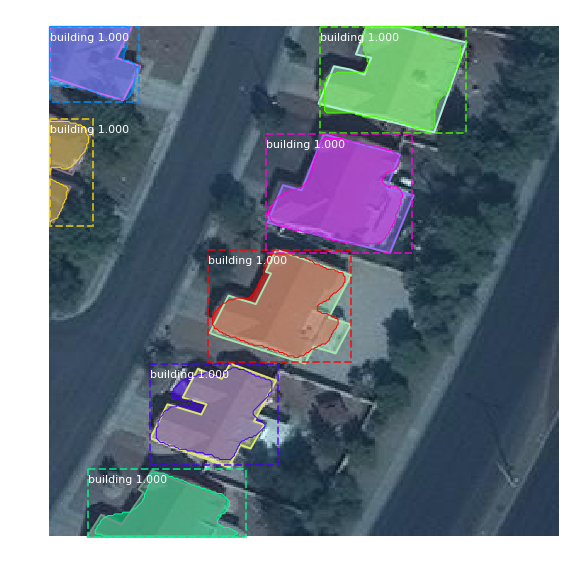

In [11]:
random_image_id = random.choice(image_ids)
#random_image_id = 62046
print(random_image_id)

def show_annotations_and_predictions(image_id):
    """
    Show a image with 3 overlays to make it easier to see the results of our model:
    - Ground truth footprint is the solid line
    - Predicted mask is the weirdly shaped mask (solid boundary line)
    - Predicted footprint is the dotted line box
    """
    img = coco.loadImgs(random_image_id)[0]
    image_path = os.path.join(IMAGE_DIR, img["file_name"])
    print(image_path)
    I = io.imread(image_path)
    annotation_ids = coco.getAnnIds(imgIds=img['id'])
    annotations = coco.loadAnns(annotation_ids)
    # load and render the image
    plt.figure(figsize=(15, 15))
    plt.imshow(I);
    # Render annotations on top of the image
    coco.showAnns(annotations)
    
    # show predictions
    predictions = model.detect([I]*config.BATCH_SIZE, verbose=0) # We are replicating the same image to fill up the batch_size
    p = predictions[0]
    # repackage predictions so that coco can calculate IoUs
    preds = []
    for _idx, r in enumerate(predictions):
        for _idx, class_id in enumerate(r["class_ids"]):
            if class_id == 1:
                mask = r["masks"].astype(np.uint8)[:, :, _idx]
                bbox = np.around(r["rois"][_idx], 1)
                bbox = [float(x) for x in bbox]
                _result = {}
                _result["image_id"] = image_id
                _result["category_id"] = 100
                _result["score"] = float(r["scores"][_idx])
                _mask = cocomask.encode(np.asfortranarray(mask))
                _mask["counts"] = _mask["counts"].decode("UTF-8")
                _result["segmentation"] = _mask
                _result["bbox"] = [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
                preds.append(_result)
    coco_preds = coco.loadRes(preds)
    cocoEval = COCOeval(coco, coco_preds, 'segm')
    cocoEval.params.imgIds = [image_id]
    cocoEval.evaluate()
    cocoEval.accumulate()
    ious = cocoEval.computeIoU(image_id, 100)

    visualize.display_instances(I, p['rois'], p['masks'], p['class_ids'], 
                            class_names, [sum(x) for x in ious], ax=plt.gca())
 
show_annotations_and_predictions(random_image_id)